# Algorithm Demonstration

<img src="images/qb_image_1.png" alt="Drawing" style="width: 400px;"/>

## Compute all possible probabilities exactly

Here we generate [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with probabilities of all basis states. 

First of all, you need to initialize the GBS device. We do not recommend running this notebook if the number of clicked detectors of the device, denoted here as `n`, is larger than 30. For a small number of clicked detectors, the approximate algorithm can go crazy.

Further we will briefly reproduce the logic of our method, which is described in detail [here](https://arxiv.org/pdf/2106.01445.pdf). 

In [1]:
from quantum_badger import *
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['svg'] 

colors = ['#8ECAE6', '#219EBC', '#023047', '#FFCB47', '#FFB703', '#FB8500', '#BB0A21']

In [2]:
path = create_path(filename='method_details.ipynb')

m = 10
#  Number of input squeezed states
n = round(m/2) 
#  Squeezing parameter of the input squeezed vacuum states
r = 1.6
#  Number of beam splitters 
n_BS = m**2

M, U = choose_default_device(m, r, path=path)

Data were exported to /Users/anastasiacertkova/Desktop/Coding/data/19_15-31_08_2023
Data were exported /Users/anastasiacertkova/Desktop/Coding/data/19_15-31_08_2023 in files initial_state.dat, parameters_of_interferometer.dat, matrix_U.dat, GBS_matrix.dat 


In [3]:
df_basis = get_basis_df(M)
df_basis.info()
df_basis.head()

Sum of Probabilities: 1.000e+00
<class 'pandas.core.frame.DataFrame'>
Index: 1024 entries, 0000000000 to 1111111111
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   n_clicks           1024 non-null   int64  
 1   probability_exact  1024 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 24.0+ KB


,n_clicks,probability_exact
sample,,
0000000000,0,0.008791
1000000000,1,0.000095
0100000000,1,0.000094
0010000000,1,0.000088
0001000000,1,0.000447


#### Find probability of a specific sample in DataFrame

In [4]:
sample = [0]*m 

# or sample ='00000' without convert_list_to_str() method

df_basis["probability_exact"].loc[convert_list_to_str(sample)] 

0.008790965232548676

#### Total probability mass function of a small Gaussian Boson Sampling device

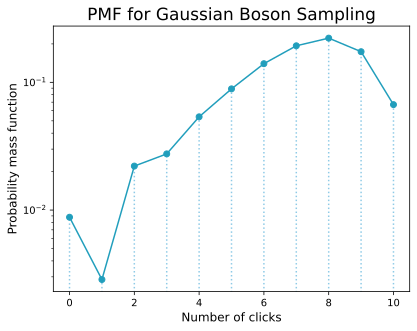

In [5]:
pmf_values = [sum(df_basis["probability_exact"][df_basis["n_clicks"] == n]) for n in range(m+1)]

plt.vlines(
    range(m+1), 
    0,
    pmf_values, 
    color = colors[0],
    linestyles='dotted'
)

plt.plot(
    range(m+1), 
    pmf_values,
    'o-',
    color = colors[1]
)

plt.yscale('log')
plt.xlabel("Number of clicks", fontsize=12)
plt.ylabel("Probability mass function", fontsize=12)
plt.title("PMF for Gaussian Boson Sampling", fontsize=17);
plt.show()

## What do sectors look like?
---
The number of detectors that show a click and the arrangement of those detectors does not tell us directly how many photons were sent out by the sources. Sometimes, more than one photon can reach a detector, but threshold detectors cannot distinguish these cases. Even though we cannot observe this, it is helpful to consider how many photons could be there. Let's call this number of injected photons $k$. In our approach, we define a sector as the probability mass function of a fixed number of photons $p_k(n)$.

The photon-number operator commutes with the experimental observables, and, therefore, $p(n)$ can be presented as a sum over sectors corresponding to different photon numbers: $p(n)=\sum_{k \ge n} p_{k}(n)$.

#### Total probability mass function of sectors 

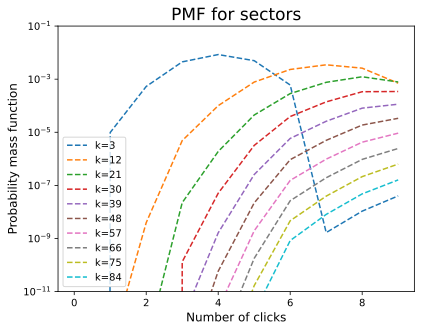

In [6]:
sample = [1]*(m-1) + [0] # just for example
n_clicked = sum(sample)

P_sectors = prob_sectors_exact(M, sample=sample)

for nu in range(int(n_clicked/3),n_clicked*10, n_clicked):
    plt.plot(
        range(n_clicked+1),
        [P_sectors[j,nu] for j in range(n_clicked+1)],
        '--' ,
        #color = colors[nu%(len(colors))],
        label = 'k='+str(nu)
)
plt.yscale('log')
plt.ylim(10**(-11), 10**(-1))
plt.legend(prop={'size':10}, loc='lower left')
plt.xlabel("Number of clicks", fontsize=12)
plt.ylabel("Probability mass function", fontsize=12)
plt.title("PMF for sectors", fontsize=17);
plt.show()

---
#### Probability mass function of sectors for a sample

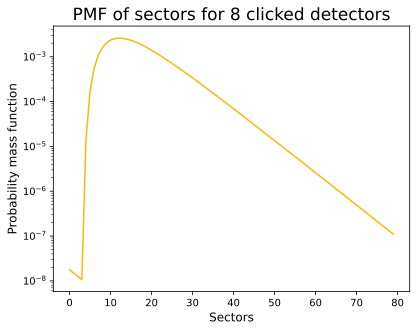

In [7]:
sample = [1]*(m-2) + [0]*2 # just for example
n_clicked = sum(sample)
nu_max = 10*n_clicked


plt.plot(
        range(nu_max),
        [P_sectors[n_clicked,nu] for nu in range(nu_max)],
        '-',
        color = colors[-3]
)
plt.yscale('log')
#plt.legend(prop={'size':10}, loc='lower left')
plt.xlabel("Sectors", fontsize=12)
plt.ylabel("Probability mass function", fontsize=12)
plt.title(f"PMF of sectors for {n_clicked} clicked detectors", fontsize=17);
plt.show()

---
#### Convergence of a sum over sectors to the exact result 

In [8]:
# Comparison of calculation of the exact probabilities with and without sectors

sample = [1]*(m-1) + [0]*1 # just for example
n_clicked = sum(sample)
nu_max = 10*n_clicked


P_sectors =  prob_sectors_exact(M, sample=sample)

P_ = 0
for nu in range(nu_max):
    P_ += P_sectors[n_clicked,nu]
    

print("Probability summed over sectors:", "{:.3e}".format(P_)) 
print("Exact probability:",
      "{:.3e}".format(df_basis["probability_exact"].loc[convert_list_to_str(sample)]))

Probability summed over sectors: 1.753e-02
Exact probability: 1.753e-02


#### Approximate sectors for a sample


In [9]:
export_samples([sample], path, "/samples.dat")
submatriсes_export(M, [sample], path)

moments = MomentUtility(id_ = 0, path=path)
moments.export_minors()
moments.export_moments()

In [10]:
cumulants = CumulantUtility(id_ = 0, path=path)

probability_approx_2, probability_approx_3, probability_approx_4 = cumulants.prob_approx(export_probabilities = False)

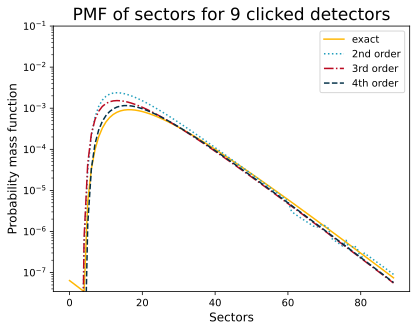

In [11]:
plt.plot(
        range(nu_max),
        [P_sectors[n_clicked,nu] for nu in range(nu_max)],
        '-', 
        color = colors[-3],
        label="exact"
)

plt.plot(
        range(nu_max),
        [probability_approx_2[nu] for nu in range(nu_max)],
        linestyle='dotted', 
        color = colors[1],
        label="2nd order"
)

plt.plot(
        range(nu_max),
        [probability_approx_3[nu] for nu in range(nu_max)],
        linestyle='dashdot', 
        color = colors[-1],
        label="3rd order"
)

plt.plot(
        range(nu_max),
        [probability_approx_4[nu] for nu in range(nu_max)],
        linestyle='dashed',
        color = colors[2],
        label="4th order"
)

plt.yscale('log')
plt.legend(prop={'size':10}, loc='upper right')
plt.ylim(min(P_sectors[n_clicked,:]), 0.1)
plt.xlabel("Sectors", fontsize=12)
plt.ylabel("Probability mass function", fontsize=12)
plt.title(f"PMF of sectors for {n_clicked} clicked detectors", fontsize=17);
plt.show()

In [12]:
print(
    " Probability summed over sectors \n",
    "-"*40,'\n',
    f"exact: {sum(P_sectors[n_clicked,:])} \n",
    f"2nd order: {sum(probability_approx_2)} \n",
    f"3rd order: {sum(probability_approx_3)} \n",
    f"4th order: {sum(probability_approx_4)} \n",
)

 Probability summed over sectors 
 ---------------------------------------- 
 exact: 0.017528701638868174 
 2nd order: 0.03762962111853375 
 3rd order: 0.02626414095945501 
 4th order: 0.020642438224282352 



--- 
### Comparison with Strawberry Fields Library

In [13]:
import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus import threshold_detection_prob

In [14]:
def sf_result(r_s, phi_s, ind, phi, psi, eta, n_bs, m):

    """
    Here we check our exact probabilities results 
    with the Walrus https://github.com/XanaduAI/thewalrus
    and Strawberry Fields https://github.com/XanaduAI/strawberryfields libraries.  
    """

    prog = sf.Program(m)

    eng = sf.Engine("gaussian")

    with prog.context as q:

        for i in range(m):

            Sgate(r_s[i], phi_s[i]) | q[i]

        for k in range(n_bs):

            Rgate(phi[k]) | q[ind[k,0]]
            BSgate(eta[k]) | (q[ind[k,1]], q[ind[k,0]])
            Rgate(psi[k]) | q[ind[k,1]]

    state = eng.run(prog).state

    mu = state.means()
    cov = state.cov()

    return mu, cov

In [15]:
r_, phi_ = import_initial_state(path, "/initial_state.dat")
ind, phi, psi, eta, n_bs, m = import_parameters_interferometer(path, "/parameters_of_interferometer.dat")

mu, cov = sf_result(r_, phi_, ind, phi, psi, eta, n_bs, m)
proba_sf = []

for s in df_basis.index.to_list():
    
    proba_sf.append(
        threshold_detection_prob(mu, cov, convert_str_to_list(s)).real
    )

    
df_basis["probability_exact_sf"] = proba_sf
proba_qb = df_basis["probability_exact"].to_list()

print(f"Fidelity between two distributions: {round(fidelity(proba_qb,proba_sf),4)}")
df_basis.head()

Fidelity between two distributions: 1.0


,n_clicks,probability_exact,probability_exact_sf
sample,,,
0000000000,0,0.008791,0.008791
1000000000,1,0.000095,0.000095
0100000000,1,0.000094,0.000094
0010000000,1,0.000088,0.000088
0001000000,1,0.000447,0.000447


---
### Noisy Interferometer Matrix Generation

A realization of the GBS device also has errors in a reconstructed interferometer matrix (a.k.a. local gate errors), which affect the output probability distribution. Stochastic measurement bias in GBS, caused by interaction with the environment, blurs the interferometer matrix and spoils the distribution. This fact should be considered when the classical simulation performance is compared with the output of a noisy quantum device. 

Here $U$ is a unitary interferometer matrix, which is composed of a set of two-mode transformations $U(\phi_1)U(\theta)U(\phi_2)$, where $U(\theta), U(\phi)$ are a beam splitter and shifter operators. To consider a moderate rate of noise in each optical element we propose to model it as a normally distributed random error in each angle of beamsplitters with $5 \%$ dispersion.

In [16]:
error = 0.05

ind, phi, psi, eta, n_bs, m = import_parameters_interferometer(path, '/parameters_of_interferometer.dat')
U_appr = interferometer_approx(n_BS, ind, phi, psi, eta, error,  m)

export_complex_matrix(path + r"/matrix_U_appr.dat", U_appr)

print("Frobenius distance between U and U_appr:", round(frobenius_distance(U, U_appr),2) )

Frobenius distance between U and U_appr: 1.08


---
### Tests for probabilities of all states for 2 interferometers 

In [17]:
df_basis_exact = get_basis_df(M)

r_s, phi_s = import_initial_state(path, '/initial_state.dat')    
A = input_matrix(r_s, phi_s, m, n)
M_appr = set_device_parameters(r, A, U_appr)

df_basis_appr = get_basis_df(M_appr)


p = df_basis_exact["probability_exact"].to_list()
q = df_basis_appr["probability_exact"].to_list()

print('-'*70)
print(f"Relative Weighted Error: {round(relative_weighted_error(p,q),4)}")
print(f"Total Variation Distance: {round(total_variation_distance(p,q),4)}")
print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(p,q),4)}")
print(f"Cosine Similarity:{round(cosine_similarity(p,q),4)}")
print(f"Fidelity: {round(fidelity(p,q),4)}")
print(f"Cross Entropy: {round(cross_entropy(p,q),4)}")

Sum of Probabilities: 1.000e+00
Sum of Probabilities: 1.000e+00
----------------------------------------------------------------------
Relative Weighted Error: 0.6943
Total Variation Distance: 0.0056
Mean Absolute Percentage Error: 0.5265
Cosine Similarity:0.9819
Fidelity: 0.9599
Cross Entropy: 8.2104
